<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
import shap

import category_encoders as ce

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error


# Data Imports and Processing


In [46]:
# Load the CSV file (update the path to match your local filesystem)
df = pd.read_csv('/content/drive/MyDrive/Project Documents ML-CMT/dataset3elements2.csv')  # e.g., './data/bandgap_dataset_premium.csv'


In [47]:
# Data inspection

print("Data shape:", df.shape)

missing = df.isnull().sum()
missing = missing[missing > 0]
print("Missing values per column:")
for col, n in missing.items():
    print(f"{col}: {n}")

display(df.describe())

Data shape: (28117, 76)
Missing values per column:
atomic_radius_1: 1
atomic_radius_2: 17
atomic_radius_3: 29
electronegativity_2: 2
avg_en: 2
max_en: 2
min_en: 2
std_en: 2


,band_gap,element1,element2,element3,molar_volume_1,molar_volume_2,molar_volume_3,sum_molar_volume,mean_molar_volume,std_molar_volume,...,std_ie,avg_am,max_am,min_am,std_am,avg_vdw,vdw_range,max_vdw,min_vdw,std_vdw
count,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,...,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000,28117.000000
mean,1.883873,23.079560,31.270050,30.084255,16.828208,16.398879,18.549773,51.776860,17.258953,6.477199,...,3.070415,65.287367,116.916372,22.338091,40.957049,1.948805,0.727881,2.316487,1.588606,0.309553
std,1.564533,21.524737,24.339381,22.037997,6.392226,9.089563,14.719467,18.000455,6.000152,6.023917,...,1.119460,33.447725,57.993254,20.822263,24.047666,0.199958,0.364067,0.356836,0.197141,0.154019
min,0.001000,1.000000,1.000000,1.000000,4.390000,4.390000,4.390000,14.530000,4.843333,0.074087,...,0.020718,5.653707,9.012182,1.007940,1.232258,1.363333,0.010000,1.520000,1.100000,0.004714
25%,0.591100,8.000000,9.000000,12.000000,14.000000,10.830000,10.000000,38.780000,12.926667,2.932909,...,2.361037,35.171747,58.933195,14.006700,19.458729,1.800000,0.520000,2.070000,1.520000,0.217000
50%,1.536700,9.000000,25.000000,23.000000,17.360000,15.760000,13.540000,47.200000,15.733333,4.220461,...,3.189195,61.910680,118.710000,15.999400,37.777741,1.933333,0.650000,2.230000,1.520000,0.273618
75%,2.849900,34.000000,50.000000,46.000000,17.360000,19.010000,19.880000,58.160000,19.386667,7.016044,...,3.654565,88.352600,164.930320,22.989769,58.400367,2.060000,0.880000,2.430000,1.750000,0.370255
max,8.596500,92.000000,94.000000,94.000000,55.760000,55.760000,70.940000,172.640000,57.546667,30.527772,...,6.834066,193.471727,244.000000,180.947880,109.495316,3.070000,2.330000,3.430000,2.750000,1.022383


In [48]:
df.columns

Index(['band_gap', 'material_id', 'elements', 'element1', 'element2',
       'element3', 'molar_volume_1', 'molar_volume_2', 'molar_volume_3',
       'sum_molar_volume', 'mean_molar_volume', 'std_molar_volume',
       'van_der_waals_radius_1', 'van_der_waals_radius_2',
       'van_der_waals_radius_3', 'atomic_radius_1', 'atomic_radius_2',
       'atomic_radius_3', 'atomic_mass_1', 'atomic_mass_2', 'atomic_mass_3',
       'ionization_energy_1', 'ionization_energy_2', 'ionization_energy_3',
       'electron_affinity_1', 'electron_affinity_2', 'electron_affinity_3',
       'electronegativity_1', 'electronegativity_2', 'electronegativity_3',
       'orbital_energy_1', 'orbital_energy_2', 'orbital_energy_3',
       'largest_with_most_missing_electron_orbital_1',
       'largest_with_most_missing_electron_orbital_2',
       'largest_with_most_missing_electron_orbital_3',
       'most_missing_electrons_orbital_1', 'most_missing_electrons_orbital_2',
       'most_missing_electrons_orbital_3', 

In [49]:
# Drop columns that are prohibited

df = df.drop(columns='elements')
df = df.drop(columns='material_id')
df = df.drop(columns='largest_with_most_missing_electron_orbital_1')
df = df.drop(columns='largest_with_most_missing_electron_orbital_2')
df = df.drop(columns='largest_with_most_missing_electron_orbital_3')

In [39]:
# df = df.drop(columns = 'categorical_orbital_1')
# df = df.drop(columns = 'categorical_orbital_2')
# df = df.drop(columns = 'categorical_orbital_3')

In [50]:
df.shape

(28117, 71)

In [51]:
target_column = "band_gap"
X = df.drop(columns=[target_column])
y = df[target_column]

# Seperate numeric and categorical columns

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

In [52]:
# To decide: drop columns with >65% missing values (can be lower, based on this dummy dataset)

threshold = 0.65
missing_frac = df.isnull().mean()
cols_to_drop = missing_frac[missing_frac > threshold].index

print(f"Dropping columns with >{int(threshold*100)}% missing values:")
print(list(cols_to_drop))

df = df.drop(columns=cols_to_drop)

# To decide: impute missing numerical values with mean, categorical features with most frequent value
# StandardScaler subtracts mean and divides by std
# Use onehotencoder for categorical features


# Split into train and test sets BEFORE preprocessing
X = df.drop("band_gap", axis=1)   # Replace "target" with your actual target column name
y = df["band_gap"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply Target Encoding on training set only
te_col = "spacegroup_number "
te_encoder = ce.TargetEncoder(cols=[te_col])
X_train[te_col] = te_encoder.fit_transform(X_train[te_col], y_train)
X_test[te_col] = te_encoder.transform(X_test[te_col])

# Proceed with rest of pre-processing pipeline
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore")
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

Dropping columns with >65% missing values:
[]


In [53]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_processed.toarray()
                              if hasattr(X_train_processed, "toarray")
                              else X_train_processed, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test_processed.toarray()
                             if hasattr(X_test_processed, "toarray")
                             else X_test_processed, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [58]:
import torch.nn as nn

class DeepRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model2 = DeepRegressor(X_train_tensor.shape[1])

In [59]:

if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Metal GPU on Mac
elif torch.cuda.is_available():
    device = torch.device("cuda")  # Use NVIDIA GPU (not on Mac usually)
else:
    device = torch.device("cpu")  # Fallback

print("Using device:", device)

model2.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

print(X_train_tensor.device)
print(y_train_tensor.device)

Using device: cuda
cuda:0
cuda:0


In [60]:
model2.train()
# Train model and register learning curve
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

train_losses = []
test_losses = []
n_epochs = 2000
model2.train()
for epoch in range(n_epochs):

    optimizer.zero_grad()
    y_pred_train = model2(X_train_tensor)
    loss = criterion(y_pred_train, y_train_tensor)
    loss.backward()
    optimizer.step()

    model2.eval()
    with torch.no_grad():
        y_pred_test = model2(X_test_tensor)
        test_loss = criterion(y_pred_test, y_test_tensor)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Test Loss={test_loss.item():.4f}")

Epoch 0: Train Loss=5.4434, Test Loss=5.3584
Epoch 10: Train Loss=5.2999, Test Loss=5.2301
Epoch 20: Train Loss=5.1671, Test Loss=5.0953
Epoch 30: Train Loss=4.9819, Test Loss=4.9046
Epoch 40: Train Loss=4.7166, Test Loss=4.6339
Epoch 50: Train Loss=4.3671, Test Loss=4.2788
Epoch 60: Train Loss=3.9225, Test Loss=3.8286
Epoch 70: Train Loss=3.3780, Test Loss=3.2829
Epoch 80: Train Loss=2.8061, Test Loss=2.7241
Epoch 90: Train Loss=2.3567, Test Loss=2.3058
Epoch 100: Train Loss=2.1468, Test Loss=2.1273
Epoch 110: Train Loss=2.0793, Test Loss=2.0663
Epoch 120: Train Loss=2.0202, Test Loss=2.0076
Epoch 130: Train Loss=1.9777, Test Loss=1.9660
Epoch 140: Train Loss=1.9423, Test Loss=1.9320
Epoch 150: Train Loss=1.9109, Test Loss=1.9025
Epoch 160: Train Loss=1.8819, Test Loss=1.8751
Epoch 170: Train Loss=1.8552, Test Loss=1.8496
Epoch 180: Train Loss=1.8299, Test Loss=1.8254
Epoch 190: Train Loss=1.8053, Test Loss=1.8018
Epoch 200: Train Loss=1.7813, Test Loss=1.7787
Epoch 210: Train Loss=1.

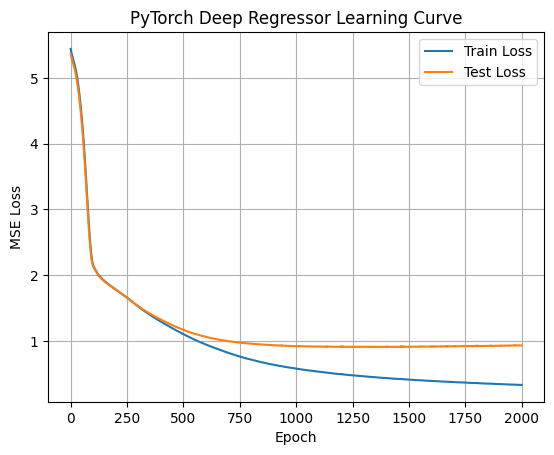

In [61]:
# Plot learning curves
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("PyTorch Deep Regressor Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [62]:
# Evaluate model
y_pred_torch = y_pred_test.detach().to("cpu").numpy()

mae_torch = mean_absolute_error(y_test, y_pred_torch)
mse_torch = mean_squared_error(y_test, y_pred_torch)
rmse_torch = np.sqrt(mse_torch)
r2_torch = r2_score(y_test, y_pred_torch)

# mae_torch = mean_absolute_error(y_test, y_pred_torch)
# mse_torch = mean_squared_error(y_test, y_pred_torch)
# rmse_torch = np.sqrt(mse_torch)
# r2_torch = r2_score(y_test, y_pred_torch)

print(f"[PyTorch Model]")
print(f"MAE:  {mae_torch:.4f}")
print(f"MSE: {mse_torch:.4f}")
print(f"RMSE: {rmse_torch:.4f}")
print(f"R²:   {r2_torch:.4f}")

[PyTorch Model]
MAE:  0.6934
MSE: 0.9307
RMSE: 0.9647
R²:   0.6189


In [63]:
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(random_state=42,  n_estimators=50, max_depth=10, n_jobs=-1)

}

In [64]:
# train models
print("\nCross-validated MAE (5-fold):")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    scores = cross_val_score(pipeline, X_train, y_train,
                             scoring="neg_mean_absolute_error", cv=5)
    print(f"{name}: MAE = {-np.mean(scores):.3f}")


Cross-validated MAE (5-fold):
Dummy: MAE = 1.271
Linear Regression: MAE = 0.989
Ridge Regression: MAE = 0.989
Random Forest: MAE = 0.742



Test set performance:
Dummy: MAE = 1.264, R² = -0.000
Linear Regression: MAE = 0.982, R² = 0.363
Ridge Regression: MAE = 0.982, R² = 0.363
Random Forest: MAE = 0.739, R² = 0.612


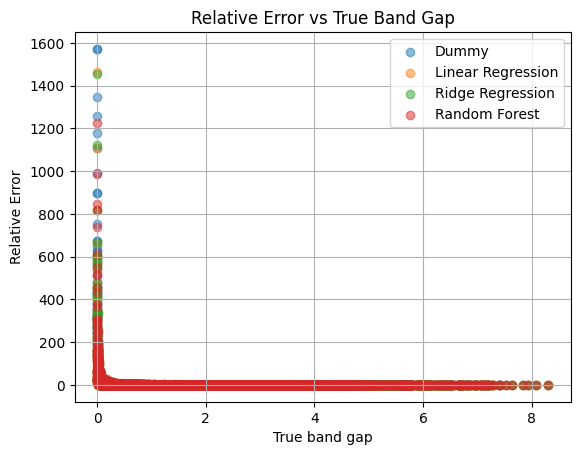

In [65]:
# Fit on full training set and evaluate on test set

results = {}
print("\nTest set performance:")
for name, model in models.items():
    pipeline = make_pipeline(preprocessor, model)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"mae": mae, "r2": r2}

    print(f"{name}: MAE = {mae:.3f}, R² = {r2:.3f}")

    # Plot MAE vs true value
    relative_error = np.abs(y_pred - y_test) / y_test
    plt.scatter(y_test, relative_error, label=name, alpha=0.5)

    #plt.scatter(y_test, np.abs(y_pred - y_test), label=name, alpha=0.5)

plt.xlabel("True band gap")
plt.ylabel("Relative Error")
plt.title("Relative Error vs True Band Gap")
plt.legend()
plt.grid(True)
plt.show()


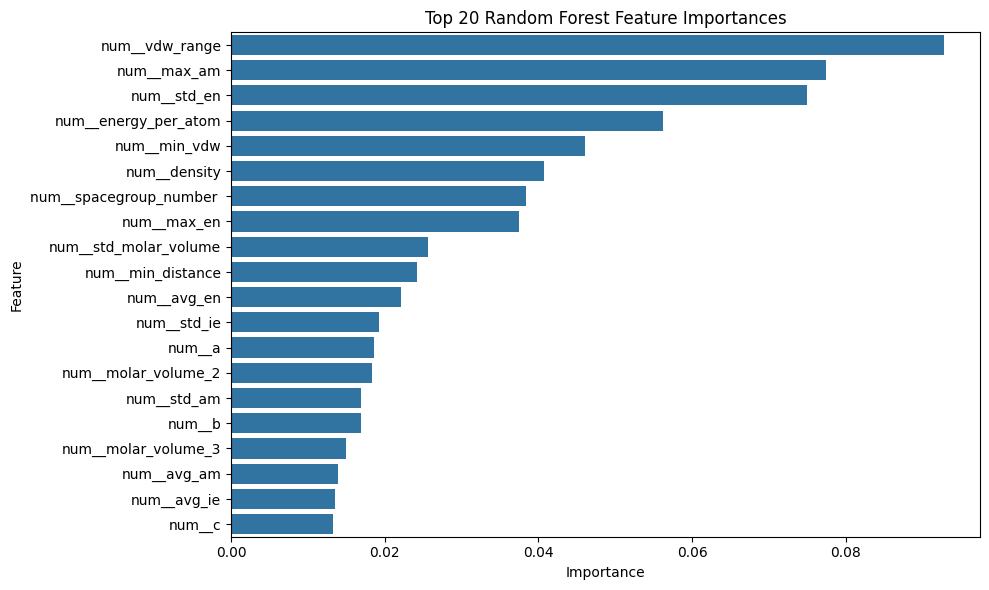

In [66]:
# Feature importance of tree based model
rf_model = make_pipeline(preprocessor, RandomForestRegressor(random_state=42))
rf_model.fit(X_train, y_train)

importances = rf_model.named_steps["randomforestregressor"].feature_importances_

# Get feature names from the preprocessor
feature_names = rf_model.named_steps["columntransformer"].get_feature_names_out()

# Sort by importance
sorted_idx = np.argsort(importances)[::-1][:20]
top_features = np.array(feature_names)[sorted_idx]
top_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
